In [ ]:
!pip install gym[classic_control]
!pip install pyglet
!pip install gym --upgrade

In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
import gym
import math
import random
import numpy as np
import collections
import statistics
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
from typing import Any, List, Sequence, Tuple

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

eps = np.finfo(np.float32).eps.item()

print("Gym version:", gym.__version__)

#env_cartpole = gym.make('MountainCar-v0',render_mode="rgb_array")
env_cartpole = gym.make('CartPole-v0',render_mode="rgb_array")

env_cartpole.reset()

plt.imshow(env_cartpole.render());

In [ ]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=1000):
    epoch_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        initial_obs, info = env.reset()
        obs = initial_obs
        for t in range(max_steps_per_episode):
            out = agent(obs)
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _, _ = env.step(out["Action"])
            total_rewards += rew
            if done:
                break
        epoch_rewards.append(total_rewards)
    return {
        "AverageEpisodicReturn": np.mean(epoch_rewards),
        "StandardDeviation": np.sqrt(np.var(epoch_rewards))
    }


from IPython.display import HTML
import matplotlib.animation

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    plt.close()
    return HTML(ani.to_jshtml())

def animate_agent(env, agent, max_steps=500):
    initial_obs, info = env.reset()
    obs = initial_obs
    frames = collections.deque()
    frames.append(env.render())
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, _ = env.step(action)
        frames.append(env.render())
        if done:
            break
    return animate_frames(frames)


def agent_left(observation):
    return {"Action":0}
def agent_right(observation):
    return {"Action":1}
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

print(average_episodic_return(env_cartpole, agent_random))

animate_agent(env_cartpole, agent_random)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


{'AverageEpisodicReturn': 20.2, 'StandardDeviation': 8.669486720677297}


In [ ]:
from tensorflow.keras import layers
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self,
      num_actions: int,
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.dense = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    x = self.dense(x)
    return self.actor(x), self.critic(x)

In [ ]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action],
                           [tf.float32, tf.int32, tf.int32])

In [ ]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

In [ ]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) /
               (tf.math.reduce_std(returns) + eps))

  return returns

In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode)

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

In [ ]:
env = env_cartpole
num_actions = env.action_space.n
num_hidden_units = 128
model = ActorCritic(num_actions, num_hidden_units)

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 1000
reward_threshold = 475
running_reward = 0
gamma = 0.99

episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
all_rewards = []

t = tqdm.trange(max_episodes)
rewards_temp = 0
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    all_rewards.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
    rewards_temp += episode_reward
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)

    if i % 50 == 0 and i != 0:
        print(f'Episode {i}: average reward: {rewards_temp/50}')
        rewards_temp = 0

    if running_reward >= reward_threshold and i >= min_episodes_criterion:
        print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')
        break


  1%|          | 55/10000 [00:07<07:26, 22.25it/s, episode_reward=22, running_reward=37.1]

Episode 50: average reward: 37.98


  1%|          | 112/10000 [00:09<03:52, 42.45it/s, episode_reward=13, running_reward=46.1]

Episode 100: average reward: 61.18


  2%|▏         | 155/10000 [00:12<11:22, 14.43it/s, episode_reward=107, running_reward=90.2]

Episode 150: average reward: 115.96


  2%|▏         | 203/10000 [00:17<10:46, 15.17it/s, episode_reward=141, running_reward=146]

Episode 200: average reward: 172.4


  3%|▎         | 252/10000 [00:24<13:26, 12.08it/s, episode_reward=151, running_reward=208]

Episode 250: average reward: 240.76


  3%|▎         | 301/10000 [00:38<45:01,  3.59it/s, episode_reward=113, running_reward=393] 

Episode 300: average reward: 546.68


  3%|▎         | 314/10000 [00:44<22:51,  7.06it/s, episode_reward=1000, running_reward=481]  


Solved at episode 314: average reward: 481.00!


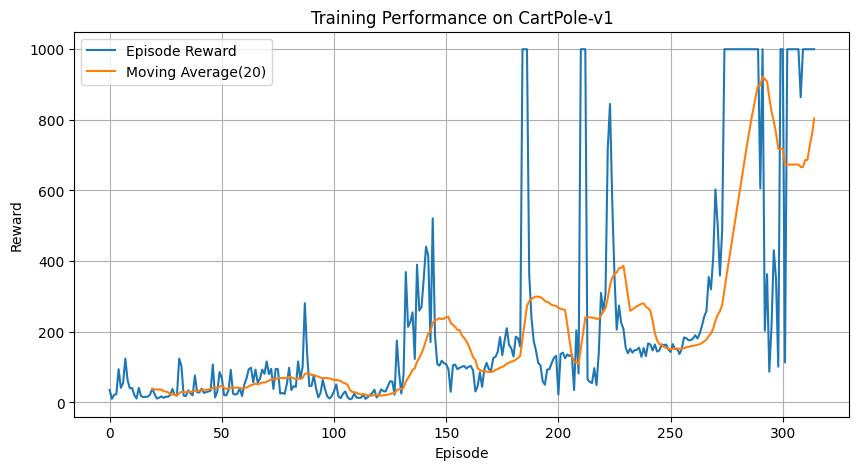

In [ ]:
window = 20

if len(all_rewards) >= window:
    smoothed_rewards = [np.mean(all_rewards[i:i+window]) for i in range(len(all_rewards)-window+1)]
else:
    smoothed_rewards = all_rewards

plt.figure(figsize=(10,5))
plt.plot(all_rewards, label="Episode Reward")
plt.plot(range(window-1, len(all_rewards)), smoothed_rewards, label=f"Moving Average({window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Performance on CartPole-v1")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def agent_actor_critic(observation):
    obs = tf.constant(observation, dtype=tf.float32)
    obs = tf.expand_dims(obs, 0)
    action_logits, _ = model(obs)
    action = np.argmax(action_logits[0].numpy())
    return {"Action": action}

print(average_episodic_return(env_cartpole, agent_actor_critic))

animate_agent(env_cartpole, agent_actor_critic)

{'AverageEpisodicReturn': 1000.0, 'StandardDeviation': 0.0}


In [ ]:
env = env_cartpole
num_actions = env.action_space.n
num_hidden_units = 128
model = ActorCritic(num_actions, num_hidden_units)

min_episodes_criterion = 100
max_episodes = 3000
max_steps_per_episode = 10000
reward_threshold = -105
running_reward = 0
gamma = 0.99

episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
all_rewards = []  # 初始化用于记录所有回合奖励的列表

t = tqdm.trange(max_episodes)
rewards_temp = 0
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    all_rewards.append(episode_reward)  # 记录每个回合的奖励
    running_reward = statistics.mean(episodes_reward)
    rewards_temp += episode_reward
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)

    if i % 50 == 0 and i != 0:
        print(f'Episode {i}: average reward: {rewards_temp/50}')
        rewards_temp = 0

    if running_reward >= reward_threshold and i >= min_episodes_criterion:
        print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')
        break


  2%|▏         | 51/3000 [02:05<45:43,  1.07it/s, episode_reward=-550, running_reward=-3.19e+3]

Episode 50: average reward: -3254.02


  3%|▎         | 101/3000 [02:34<20:47,  2.32it/s, episode_reward=-554, running_reward=-1956.92]

Episode 100: average reward: -859.82


  5%|▌         | 151/3000 [02:51<15:24,  3.08it/s, episode_reward=-395, running_reward=-680]

Episode 150: average reward: -501.12


  7%|▋         | 202/3000 [03:06<09:10,  5.08it/s, episode_reward=-245, running_reward=-469]

Episode 200: average reward: -445.34


  8%|▊         | 251/3000 [03:18<09:52,  4.64it/s, episode_reward=-264, running_reward=-405]

Episode 250: average reward: -364.98


 10%|█         | 301/3000 [03:29<13:51,  3.25it/s, episode_reward=-249, running_reward=-340]

Episode 300: average reward: -315.0


 12%|█▏        | 352/3000 [03:38<06:49,  6.47it/s, episode_reward=-218, running_reward=-300]

Episode 350: average reward: -291.68


 13%|█▎        | 402/3000 [03:48<07:50,  5.52it/s, episode_reward=-233, running_reward=-275]

Episode 400: average reward: -259.28


 15%|█▌        | 452/3000 [03:58<09:24,  4.52it/s, episode_reward=-219, running_reward=-258]

Episode 450: average reward: -257.0


 17%|█▋        | 501/3000 [04:06<08:03,  5.17it/s, episode_reward=-312, running_reward=-270]

Episode 500: average reward: -281.66


 18%|█▊        | 551/3000 [04:16<05:58,  6.82it/s, episode_reward=-249, running_reward=-277]

Episode 550: average reward: -272.5


 20%|██        | 601/3000 [04:24<07:28,  5.35it/s, episode_reward=-193, running_reward=-243]

Episode 600: average reward: -212.96


 22%|██▏       | 652/3000 [04:32<05:47,  6.76it/s, episode_reward=-229, running_reward=-213]

Episode 650: average reward: -217.96


 23%|██▎       | 701/3000 [04:40<09:26,  4.06it/s, episode_reward=-302, running_reward=-226]

Episode 700: average reward: -234.38


 25%|██▌       | 752/3000 [04:48<05:39,  6.62it/s, episode_reward=-237, running_reward=-234]

Episode 750: average reward: -234.18


 27%|██▋       | 802/3000 [04:57<05:22,  6.81it/s, episode_reward=-337, running_reward=-232]

Episode 800: average reward: -227.06


 28%|██▊       | 852/3000 [05:04<04:25,  8.08it/s, episode_reward=-214, running_reward=-226]

Episode 850: average reward: -225.98


 30%|███       | 902/3000 [05:11<04:24,  7.93it/s, episode_reward=-200, running_reward=-204]

Episode 900: average reward: -184.12


 32%|███▏      | 952/3000 [05:17<03:50,  8.89it/s, episode_reward=-217, running_reward=-187]

Episode 950: average reward: -189.3


 33%|███▎      | 1002/3000 [05:24<04:08,  8.05it/s, episode_reward=-242, running_reward=-185]

Episode 1000: average reward: -179.32


 35%|███▌      | 1053/3000 [05:30<03:12, 10.09it/s, episode_reward=-163, running_reward=-173]

Episode 1050: average reward: -167.38


 37%|███▋      | 1102/3000 [05:36<05:50,  5.41it/s, episode_reward=-165, running_reward=-167]

Episode 1100: average reward: -168.9


 38%|███▊      | 1152/3000 [05:42<02:56, 10.46it/s, episode_reward=-145, running_reward=-164]

Episode 1150: average reward: -159.12


 40%|████      | 1202/3000 [05:48<04:30,  6.65it/s, episode_reward=-143, running_reward=-165]

Episode 1200: average reward: -171.9


 42%|████▏     | 1252/3000 [05:54<03:26,  8.47it/s, episode_reward=-166, running_reward=-169]

Episode 1250: average reward: -165.46


 43%|████▎     | 1302/3000 [06:05<05:01,  5.64it/s, episode_reward=-245, running_reward=-238]

Episode 1300: average reward: -307.6


 45%|████▌     | 1353/3000 [06:10<02:12, 12.46it/s, episode_reward=-94, running_reward=-232]

Episode 1350: average reward: -162.0


 47%|████▋     | 1403/3000 [06:14<02:11, 12.18it/s, episode_reward=-113, running_reward=-140]

Episode 1400: average reward: -122.96


 48%|████▊     | 1451/3000 [06:23<04:14,  6.09it/s, episode_reward=-156, running_reward=-174]

Episode 1450: average reward: -225.2


 50%|█████     | 1502/3000 [06:30<02:56,  8.49it/s, episode_reward=-142, running_reward=-224]

Episode 1500: average reward: -222.24


 52%|█████▏    | 1552/3000 [06:36<02:14, 10.78it/s, episode_reward=-130, running_reward=-182]

Episode 1550: average reward: -143.48


 53%|█████▎    | 1602/3000 [06:41<02:02, 11.45it/s, episode_reward=-152, running_reward=-139]

Episode 1600: average reward: -132.34


 55%|█████▌    | 1652/3000 [06:55<02:28,  9.09it/s, episode_reward=-114, running_reward=-249]

Episode 1650: average reward: -366.68


 57%|█████▋    | 1702/3000 [07:00<03:03,  7.09it/s, episode_reward=-127, running_reward=-257]

Episode 1700: average reward: -147.06


 58%|█████▊    | 1753/3000 [07:05<01:32, 13.46it/s, episode_reward=-147, running_reward=-133]

Episode 1750: average reward: -118.6


 60%|██████    | 1803/3000 [07:09<01:43, 11.61it/s, episode_reward=-89, running_reward=-128]

Episode 1800: average reward: -137.72


 62%|██████▏   | 1852/3000 [07:15<02:47,  6.86it/s, episode_reward=-160, running_reward=-138]

Episode 1850: average reward: -136.92


 63%|██████▎   | 1902/3000 [07:19<01:19, 13.89it/s, episode_reward=-130, running_reward=-126]

Episode 1900: average reward: -115.68


 65%|██████▌   | 1952/3000 [07:23<01:22, 12.71it/s, episode_reward=-141, running_reward=-116]

Episode 1950: average reward: -116.06


 67%|██████▋   | 2002/3000 [07:28<02:11,  7.60it/s, episode_reward=-106, running_reward=-119]

Episode 2000: average reward: -122.6


 68%|██████▊   | 2053/3000 [07:33<01:12, 13.12it/s, episode_reward=-141, running_reward=-121]

Episode 2050: average reward: -119.28


 70%|███████   | 2103/3000 [07:36<01:06, 13.49it/s, episode_reward=-121, running_reward=-112]

Episode 2100: average reward: -105.34


 72%|███████▏  | 2151/3000 [07:40<01:08, 12.35it/s, episode_reward=-110, running_reward=-108]

Episode 2150: average reward: -109.96


 73%|███████▎  | 2177/3000 [07:42<02:54,  4.70it/s, episode_reward=-104, running_reward=-103]


Solved at episode 2177: average reward: -103.35!


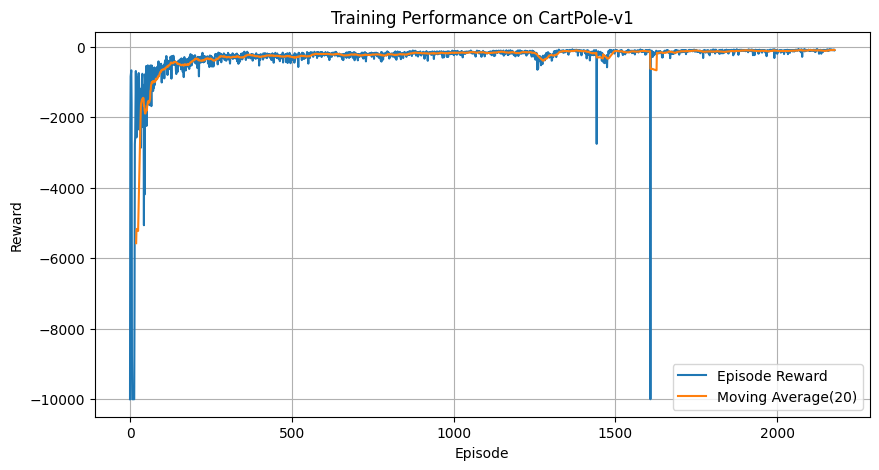

In [ ]:
window = 20

if len(all_rewards) >= window:
    smoothed_rewards = [np.mean(all_rewards[i:i+window]) for i in range(len(all_rewards)-window+1)]
else:
    smoothed_rewards = all_rewards

plt.figure(figsize=(10,5))
plt.plot(all_rewards, label="Episode Reward")
plt.plot(range(window-1, len(all_rewards)), smoothed_rewards, label=f"Moving Average({window})")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Performance on CartPole-v1")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def agent_actor_critic(observation):
    obs = tf.constant(observation, dtype=tf.float32)
    obs = tf.expand_dims(obs, 0)
    action_logits, _ = model(obs)
    action = np.argmax(action_logits[0].numpy())
    return {"Action": action}


print(average_episodic_return(env_cartpole, agent_actor_critic))

animate_agent(env_cartpole, agent_actor_critic)

{'AverageEpisodicReturn': -348.0, 'StandardDeviation': 426.8531363361408}
